In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# include only those gestures
CONDITIONS = ['like', 'dislike', 'stop', 'rock', 'peace']

# Path to data
DATA_PATH = "/home/raphi/Documents/Universität/Master/SS 23/ITT/Exercises/Exercise-06"

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

2023-06-11 17:19:13.397889: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 17:19:13.709719: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 17:19:13.711700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 17:19:15.352881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Helper function to load and parse annotations

In [2]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{DATA_PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

# Helper function for pre-processing

In [3]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## Load images and annotations

In [4]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in os.listdir(f'{DATA_PATH}/{condition}'):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{DATA_PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

## Split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1301
326
1301
326


## Transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [6]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(1301, 64, 64, 3) (326, 64, 64, 3) (1301, 6) (326, 6)


In [7]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## Train the model

In [8]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
163/163 [==============================] - 18s 100ms/step - loss: 1.8040 - accuracy: 0.2060 - val_loss: 1.8017 - val_accuracy: 0.1933 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 16s 95ms/step - loss: 1.7910 - accuracy: 0.2221 - val_loss: 1.7330 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 16s 95ms/step - loss: 1.6767 - accuracy: 0.3151 - val_loss: 1.4609 - val_accuracy: 0.4233 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 15s 93ms/step - loss: 1.3965 - accuracy: 0.4327 - val_loss: 1.0591 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 5/50
163/163 [==============================] - 15s 94ms/step - loss: 1.0862 - accuracy: 0.5603 - val_loss: 0.8174 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 6/50
163/163 [==============================] - 15s 94ms/step - loss: 0.8273 - accuracy: 0.6964 - val_loss: 0.6014 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 7/50
163/163 [==============================] - 16s

In [9]:
# let's have a look at our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_contrast (RandomCont  (None, 64, 64, 3)        0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0

## Plot accuracy and loss of the training process

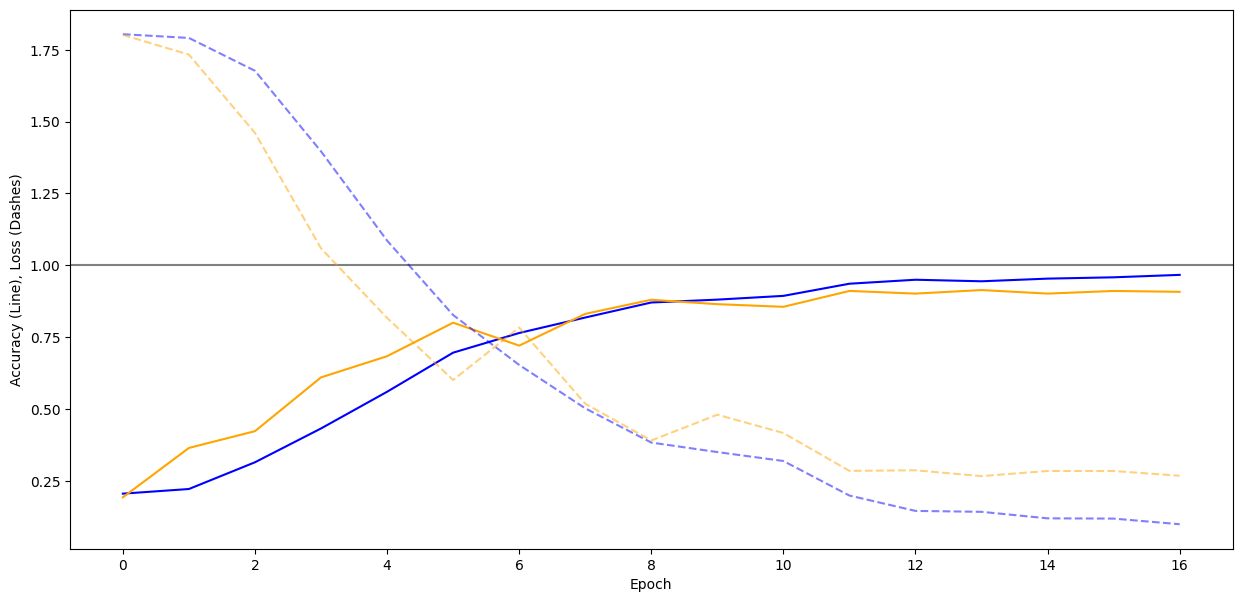

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

# Save the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [11]:
model.save('trained_gesture_model')

2023-06-11 17:24:48.814598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,64,64,3]
	 [[{{node random_flip_input}}]]
2023-06-11 17:24:49.061383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,64,3]
	 [[{{node inputs}}]]
2023-06-11 17:24:49.124029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,64

INFO:tensorflow:Assets written to: trained_gesture_model/assets


INFO:tensorflow:Assets written to: trained_gesture_model/assets


# Visualize classification results with a confusion matrix

11/11 [==============================] - 1s 85ms/step
before [[5.6519621e-06 1.1667984e-05 4.2140138e-05 9.9992532e-01 2.7757204e-07
  1.4885726e-05]
 [5.2356889e-04 6.5620072e-05 1.6775452e-05 2.0952604e-05 9.4910979e-01
  5.0263252e-02]
 [3.5499572e-03 5.8810303e-05 8.6963209e-06 2.1534554e-06 9.2518073e-01
  7.1199663e-02]
 ...
 [1.0000000e+00 7.8640285e-09 3.2169674e-09 1.8184656e-09 4.2783086e-08
  1.5618463e-09]
 [1.8323561e-05 9.5675707e-05 1.6480088e-06 9.9988270e-01 3.5240416e-07
  1.3583924e-06]
 [5.1114676e-03 3.5363646e-05 2.2508211e-05 7.4999011e-06 9.8018634e-01
  1.4636879e-02]]
probabilities [3 4 4 0 1 4 3 3 5 1 5 0 2 0 0 5 1 2 0 0 1 0 4 1 4 0 0 1 5 1 3 2 5 3 1 0 1
 0 0 3 2 0 0 2 3 0 4 4 4 5 3 3 1 3 0 1 1 4 2 1 1 5 4 4 4 1 0 2 1 2 2 3 5 1
 1 1 3 0 0 2 5 3 1 0 0 2 0 1 4 1 0 0 0 2 5 0 5 1 3 2 5 0 0 0 3 1 4 4 4 5 2
 2 0 0 1 4 2 2 4 0 4 2 4 2 1 5 0 2 3 4 0 4 3 1 1 0 2 1 5 2 3 2 1 1 2 4 4 3
 0 0 1 2 3 3 2 0 0 4 5 5 4 5 0 0 5 0 0 5 3 2 0 0 2 0 0 2 4 0 2 0 5 2 4 2 4
 3 4 5 0 5

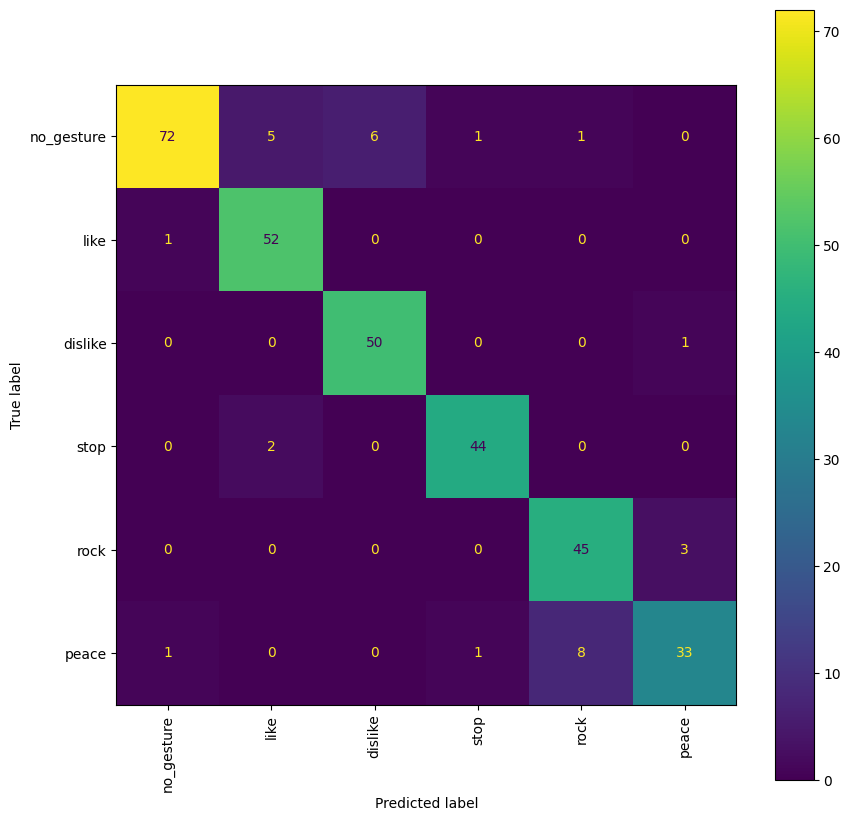

In [12]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass